## Import training/test files in Pandas

In [1]:
import pandas as pd
import os 

print(os.getcwd())

/home/ubuntu/Desktop/multi-task-learning


In [2]:
train_data = pd.read_csv(os.path.join(os.getcwd() + '/data/training_csv'))
test_data = pd.read_csv(os.path.join(os.getcwd() + '/data/test_csv'))

In [3]:
# Note: we are enabling eager execution for debugging!

import numpy as np
import tensorflow as tf
tf.enable_eager_execution()

/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/envs/mondeique

In [4]:
# Example code for handling datasets
import matplotlib.pyplot as plt

# Load filenames and labels
filenames = tf.constant(train_data.iloc[:, 0].tolist())
labels = tf.constant(train_data.iloc[:, 1:].values)

# Add to a dataset object
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

# We can debug using eager execution
for img, labels in dataset.batch(4).take(1):
    print(img)
    print(labels)

tf.Tensor(
[b'./data/cropped-bag-images-dev/5O2BQILGU6S_1.jpg'
 b'./data/cropped-bag-images-dev/X63VMOKHOQY_1.jpg'
 b'./data/cropped-bag-images-dev/TGEWLADRYBR_1.jpg'
 b'./data/cropped-bag-images-dev/SQJAPKTWWFJ_2.jpg'], shape=(4,), dtype=string)
tf.Tensor(
[[1]
 [4]
 [9]
 [1]], shape=(4, 1), dtype=int64)


In [5]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.

def _parse_function(filename, label):
    print(filename)
    image_string = tf.read_file(filename) 
    print(image_string)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3) # Channels needed because some test images are b/w
    image_resized = tf.image.resize_images(image_decoded, [40, 40])
    image_shape = tf.cast(tf.shape(image_decoded), tf.float32)
#   label = tf.concat([label[:]], axis=0)
    return {"x": image_resized}, label

## Make Dataset

In [6]:
# This snippet is adapted from here: https://www.tensorflow.org/guide/datasets
def input_fn(dataframe, is_eval=False):

    # Load the list of files
    filenames = tf.constant(dataframe.iloc[:, 0].tolist())

    # Load the labels
    labels = tf.constant(dataframe.iloc[:, 1:].values.astype(np.float32))

    # Build the dataset with image processing on top of it
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(_parse_function)

    # Add shuffling and repeatition if training
    if is_eval:
        dataset = dataset.batch(64)
    else:
        dataset = dataset.repeat().shuffle(1000).batch(64)

    return dataset

Tensor("args_0:0", shape=(), dtype=string)
Tensor("ReadFile:0", shape=(), dtype=string)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([4.], shape=(1,), dtype=float32)


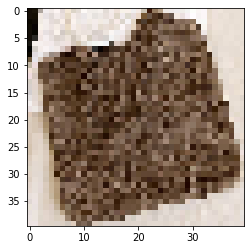

In [7]:
# Check the image & some labels
import matplotlib.pyplot as plt
for (imgs, labels) in input_fn(train_data, is_eval=True).take(1):
    plt.imshow(imgs['x'][0] / 255)
    print(labels[0])
    print(labels[1])

## Standard classical estimator (single-task only!)

### Reimplement the feature extraction from the original paper

In [8]:
def extract_features(features):
    # Input layer
    input_layer = tf.reshape(features["x"], [-1, 40, 40, 3])

    # First convolutive layer
    conv1 = tf.layers.conv2d(inputs=input_layer, filters=16, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Second convolutive layer
    conv2 = tf.layers.conv2d(inputs=pool1, filters=48, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Third convolutive layer
    conv3 = tf.layers.conv2d(inputs=pool2, filters=64, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)

    # Fourth convolutive layer
    conv4 = tf.layers.conv2d(inputs=pool3, filters=64, kernel_size=[2, 2], padding="same", activation=tf.nn.relu)

    # Dense Layer
    flat = tf.reshape(conv4, [-1, 5 * 5 * 64])
    dense = tf.layers.dense(inputs=flat, units=100, activation=tf.nn.relu)
  
    return dense

### single task cnn model

In [9]:
# Adapted from here: https://www.tensorflow.org/tutorials/layers
def single_task_cnn_model_fn(features, labels, mode):
  
    # Get features
    dense = extract_features(features)
  
    # Make predictions
    predictions = tf.layers.dense(inputs=dense, units=1)

    outputs = {
        "predictions": predictions
    }

    # We just want the predictions
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=outputs)

    # If not in mode.PREDICT, compute the loss (mean squared error)
    loss = tf.losses.mean_squared_error(labels=labels[:], predictions=predictions)

    # Single optimization step
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer()
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # If not PREDICT or TRAIN, then we are evaluating the model
    eval_metric_ops = {
        "rmse": tf.metrics.root_mean_squared_error(
            labels=labels[:], predictions=outputs["predictions"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

### Build the Estimator

In [10]:
single_task_classifier = tf.estimator.Estimator(
    model_fn=single_task_cnn_model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp0wdge__z', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7ef01faf90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Train & evaluate & test model

In [11]:
# Train the model
single_task_classifier.train(input_fn=lambda: input_fn(train_data), steps=10000)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Tensor("args_0:0", shape=(), dtype=string)
Tensor("ReadFile:0", shape=(), dtype=string)
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.dense instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp0wdge__z/model.ckpt.
INFO:tensorflow:loss = 123.460266, step = 1
INFO:tensorflow:global_step/sec: 7.09901
INFO:tensorflow:loss = 5.599771, step = 101 (14.087 sec)
INFO:tensorflow:global_step/sec: 7.3033
INFO:tensorflow:loss = 3.400456, step = 201 (13.692 sec)
INFO:tensorflow:global_step/sec: 7.12665
INFO:tensorflow:loss = 3.0372272, step = 301 (14.032 sec)
INFO:tensorflow:global_step/sec: 7.25993
INFO:tensorflow:loss = 1.8506205, step = 401 (13.774 sec)
INFO:tensorflow:global_step/sec: 7.29708
INFO:tensorflow:loss = 0.53853714, step = 501 (13.704 sec)
INFO:tensorflow:global_step/sec: 7.31659
INFO:tensorflow:loss = 0.6357757, step = 601 (13.6

INFO:tensorflow:global_step/sec: 7.22328
INFO:tensorflow:loss = 0.22462505, step = 5501 (13.844 sec)
INFO:tensorflow:global_step/sec: 7.32346
INFO:tensorflow:loss = 0.05653099, step = 5601 (13.655 sec)
INFO:tensorflow:global_step/sec: 7.14532
INFO:tensorflow:loss = 0.036731444, step = 5701 (13.995 sec)
INFO:tensorflow:global_step/sec: 7.26094
INFO:tensorflow:loss = 0.012891032, step = 5801 (13.772 sec)
INFO:tensorflow:global_step/sec: 7.31662
INFO:tensorflow:loss = 0.010920709, step = 5901 (13.668 sec)
INFO:tensorflow:global_step/sec: 7.33134
INFO:tensorflow:loss = 0.009499912, step = 6001 (13.640 sec)
INFO:tensorflow:global_step/sec: 7.19284
INFO:tensorflow:loss = 0.010677032, step = 6101 (13.903 sec)
INFO:tensorflow:global_step/sec: 7.28356
INFO:tensorflow:loss = 0.059183806, step = 6201 (13.729 sec)
INFO:tensorflow:global_step/sec: 7.2601
INFO:tensorflow:loss = 0.15838788, step = 6301 (13.774 sec)
INFO:tensorflow:global_step/sec: 7.33384
INFO:tensorflow:loss = 0.226401, step = 6401 

In [12]:
single_task_classifier.evaluate(input_fn=lambda: input_fn(test_data, is_eval=True))

Tensor("args_0:0", shape=(), dtype=string)
Tensor("ReadFile:0", shape=(), dtype=string)
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-11-12T19:35:58Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/tmp0wdge__z/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-11-12-19:35:59
INFO:tensorflow:Saving dict for global step 10000: global_step = 10000, loss = 4.411903, rmse = 2.1081843
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10000: /tmp/tmp0wdge__z/model.ckpt-10000


{'loss': 4.411903, 'rmse': 2.1081843, 'global_step': 10000}

In [13]:
p = list(single_task_classifier.predict(lambda: input_fn(test_data, is_eval=True)))

Tensor("args_0:0", shape=(), dtype=string)
Tensor("ReadFile:0", shape=(), dtype=string)
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp0wdge__z/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [16]:
p

[{'predictions': array([3.2675166], dtype=float32)},
 {'predictions': array([4.72802], dtype=float32)},
 {'predictions': array([3.4376438], dtype=float32)},
 {'predictions': array([7.088169], dtype=float32)},
 {'predictions': array([4.0717216], dtype=float32)},
 {'predictions': array([3.0803285], dtype=float32)},
 {'predictions': array([2.5117178], dtype=float32)},
 {'predictions': array([5.51766], dtype=float32)},
 {'predictions': array([4.432986], dtype=float32)},
 {'predictions': array([2.694408], dtype=float32)},
 {'predictions': array([6.6536746], dtype=float32)},
 {'predictions': array([6.3357353], dtype=float32)},
 {'predictions': array([9.831923], dtype=float32)},
 {'predictions': array([7.4845657], dtype=float32)},
 {'predictions': array([5.444915], dtype=float32)},
 {'predictions': array([5.2777286], dtype=float32)},
 {'predictions': array([6.1555133], dtype=float32)},
 {'predictions': array([8.189436], dtype=float32)},
 {'predictions': array([2.1123526], dtype=float32)},
 {'

Tensor("args_0:0", shape=(), dtype=string)
Tensor("ReadFile:0", shape=(), dtype=string)
[3.740631]
It is CIRCLE


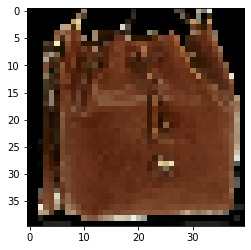

In [30]:
# Evaluate a single prediction
for imgs, _ in input_fn(test_data, is_eval=True).take(1):
    img_idx = 0
    plt.imshow(imgs["x"][img_idx] / 255)
    print(p[img_idx]['predictions'])
    if 0 < p[img_idx]['predictions'][0] < 1.5:
        print("It is SQUARE")
    elif 1.5 <= p[img_idx]['predictions'][0] < 2.5:
        print("It is TRAPEZOID")
    elif 2.5 <= p[img_idx]['predictions'][0] < 3.5:
        print("It is U_TRAPEZOID")
    elif 3.5 <= p[img_idx]['predictions'][0] < 4.5:
        print("It is CIRCLE")
    elif 4.5 <= p[img_idx]['predictions'][0] < 5.5:
        print("It is HALF_CIRCLE")
    elif 5.5 <= p[img_idx]['predictions'][0] < 6.5:
        print("It is U_HALF_CIRCLE")
    elif 6.5 <= p[img_idx]['predictions'][0] < 7.5:
        print("It is HOBO")
    elif 7.5 <= p[img_idx]['predictions'][0] < 8.5:
        print("It is BUCKET")
    elif 8.5 <= p[img_idx]['predictions'][0] < 9.5:
        print("It is BAKCPACK")

## Simplifying the code of the custom estimator with the Head API

In [ ]:
# Check the code here: https://www.tensorflow.org/api_docs/python/tf/contrib/estimator/regression_head

def single_head_cnn_model_fn(features, labels, mode):

    dense = extract_features(features)

    # Predictions
    predictions = tf.layers.dense(inputs=dense, units=2)

    # Optimizer
    optimizer = tf.train.AdamOptimizer()

    # Define the head
    regression_head = tf.contrib.estimator.regression_head(label_dimension=2)
    return regression_head.create_estimator_spec(features, mode, predictions, labels[:, 2:8:5], optimizer)

In [ ]:
# Create the Estimator
cnn_classifier = tf.estimator.Estimator(
    model_fn=single_head_cnn_model_fn, model_dir="/tmp/cnn_single_head")

## Multi-task learning with the Head API

In [ ]:
# Need to disable the eager execution at this point
import numpy as np
import tensorflow as tf

In [ ]:
def multihead_input_fn(data, is_eval=False):
    features, labels = input_fn(data, is_eval=is_eval).make_one_shot_iterator().get_next() # Why?
    return features, {'head_nose': labels[:, 2:8:5], 'head_pose': tf.cast(labels[:, -1] - 1.0, tf.int32)}

In [ ]:
def multi_head_cnn_model_fn(features, labels, mode):

    dense = extract_features(features)

    # Predictions for each task
    predictions_nose = tf.layers.dense(inputs=dense, units=2)
    predictions_pose = tf.layers.dense(inputs=dense, units=5)
    logits = {'head_nose': predictions_nose, 'head_pose': predictions_pose}

    # Optimizer
    optimizer = tf.train.AdamOptimizer()

    # Double head
    regression_head = tf.contrib.estimator.regression_head(name='head_nose', label_dimension=2)
    classification_head = tf.contrib.estimator.multi_class_head(name='head_pose', n_classes=5)

    # Multi head combining two single heads
    multi_head = tf.contrib.estimator.multi_head([regression_head, classification_head])

    return multi_head.create_estimator_spec(features, mode, logits, labels, optimizer)

### Create the Estimator

In [ ]:
multitask_classifier = tf.estimator.Estimator(model_fn=multi_head_cnn_model_fn)

### Train & evaluate & test model

In [ ]:
# Train the model
multitask_classifier.train(input_fn=lambda: multihead_input_fn(train_data), steps=1000)

In [ ]:
multitask_classifier.evaluate(input_fn=lambda: multihead_input_fn(test_data, is_eval=True))

In [ ]:
p = list(multitask_classifier.predict(lambda: input_fn(test_data, is_eval=True)))
print(p[0])